In [1]:
%matplotlib inline

In [2]:
import pandas as pd


import numpy as np


import xgboost as xgb
# machine learning
from xgboost.sklearn import XGBRegressor
from sklearn import cross_validation, metrics #Additional scklearn functions 
from sklearn.grid_search import GridSearchCV #Perforing grid search


import matplotlib.pylab as plt 
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 24, 8

/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
# get training & test csv files as a DataFrame
df_train = pd.read_csv("../input/train.csv" )
df_test    = pd.read_csv("../input/test.csv")

In [5]:
y_train = np.log(df_train['loss'].ravel())

X_train = df_train.copy()
X_test = df_test.copy()

X_train.drop(['id', 'loss'], axis=1, inplace=True)
X_test.drop(['id'], axis=1, inplace=True)



In [6]:
print("{},{}".format(X_train.shape, X_test.shape))

ntrain = X_train.shape[0]
train_test = pd.concat((X_train, X_test)).reset_index(drop=True)

features = X_train.columns

cats = [feat for feat in features if 'cat' in feat]
for feat in cats:
    train_test[feat] = pd.factorize(train_test[feat], sort=True)[0]

print(train_test.head())

X_train = np.array(train_test.iloc[:ntrain,:])
X_test = np.array(train_test.iloc[ntrain:,:])

print("{},{}".format(X_train.shape, X_test.shape))


(188318, 130),(125546, 130)
   cat1  cat2  cat3  cat4  cat5  cat6  cat7  cat8  cat9  cat10    ...     \
0     0     1     0     1     0     0     0     0     1      0    ...      
1     0     1     0     0     0     0     0     0     1      1    ...      
2     0     1     0     0     1     0     0     0     1      1    ...      
3     1     1     0     1     0     0     0     0     1      0    ...      
4     0     1     0     1     0     0     0     0     1      1    ...      

      cont5     cont6     cont7    cont8    cont9   cont10    cont11  \
0  0.310061  0.718367  0.335060  0.30260  0.67135  0.83510  0.569745   
1  0.885834  0.438917  0.436585  0.60087  0.35127  0.43919  0.338312   
2  0.397069  0.289648  0.315545  0.27320  0.26076  0.32446  0.381398   
3  0.422268  0.440945  0.391128  0.31796  0.32128  0.44467  0.327915   
4  0.704268  0.178193  0.247408  0.24564  0.22089  0.21230  0.204687   

     cont12    cont13    cont14  
0  0.594646  0.822493  0.714843  
1  0.366307  0

In [8]:
from sklearn.metrics import mean_absolute_error

def xg_eval_mae(yhat, T_train_xgb):
    y = T_train_xgb.get_label()
    return 'mae', mean_absolute_error(np.exp(y), np.exp(yhat))

def modelfit(alg, X_train, y_train,useTrainCV=True, cv_folds=5, early_stopping_rounds=20): 
    if useTrainCV: 
        xgb_param = alg.get_xgb_params() 
        xgtrain = xgb.DMatrix(X_train, label=y_train) 
        cvresult = xgb.cv(xgb_param, xgtrain,  num_boost_round=alg.get_params()['n_estimators'], 
                          nfold=cv_folds, seed=2016, stratified=False, early_stopping_rounds=early_stopping_rounds, 
                          verbose_eval=10, show_stdv=True, feval=xg_eval_mae, maximize=False)
        
        alg.set_params(n_estimators=cvresult.shape[0]) 
    #Fit the algorithm on the data 
    alg.fit(X_train, y_train,eval_metric='mae') 
    #Predict training set: 
    dtrain_predictions = alg.predict(X_train) 
    #dtrain_predprob = alg.predict_proba(X_train)[:,1] 

    cv_mean = cvresult.iloc[-1, 0]
    cv_std = cvresult.iloc[-1, 1]
    print('CV-Mean: {0}+{1}'.format(cv_mean, cv_std))
    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False) 
    feat_imp.plot(kind='bar', title='Feature Importances') 
    plt.ylabel('Feature Importance Score')

[0]	train-mae:3030.36+1.1655	train-rmse:5.79765+0.000297607	test-mae:3030.36+4.65948	test-rmse:5.79767+0.000881175
[10]	train-mae:1802.04+1.56107	train-rmse:0.856238+0.000813888	test-mae:1803.49+4.73069	test-rmse:0.857575+0.000922061
[20]	train-mae:1235.62+1.85529	train-rmse:0.566486+0.000649809	test-mae:1243.21+4.74888	test-rmse:0.569954+0.00113959
[30]	train-mae:1180.32+0.738669	train-rmse:0.551208+0.000272831	test-mae:1192.64+4.66225	test-rmse:0.556213+0.000920807
[40]	train-mae:1162.48+0.858425	train-rmse:0.544972+0.000493318	test-mae:1178.15+4.17503	test-rmse:0.551318+0.00082381
[50]	train-mae:1151.71+0.83521	train-rmse:0.540682+0.000186229	test-mae:1171.28+4.03744	test-rmse:0.548462+0.000841116
[60]	train-mae:1144.08+1.36472	train-rmse:0.537503+0.000182667	test-mae:1166.53+4.37988	test-rmse:0.546468+0.000946228
[70]	train-mae:1138.25+1.5799	train-rmse:0.534961+0.000331501	test-mae:1163.73+3.99974	test-rmse:0.545173+0.00105623
[80]	train-mae:1132.96+1.64224	train-rmse:0.532682+0.0

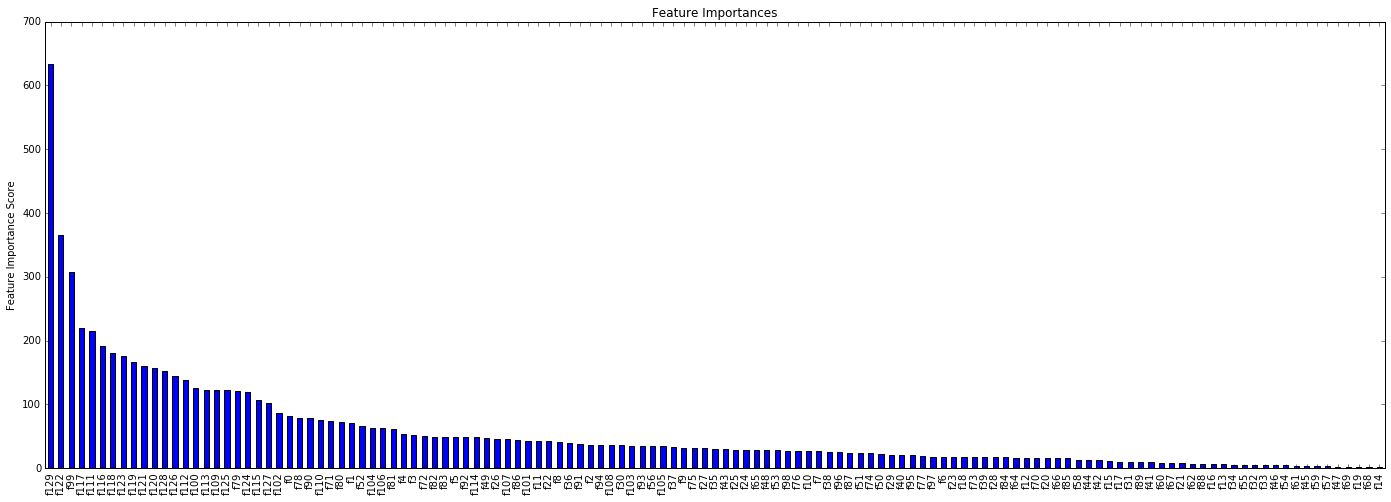

In [22]:
# predictors = [x for x in X_train.columns ] 
xgb1 = XGBRegressor( learning_rate =0.2, 
                     n_estimators=1000, 
                     max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, 
                     colsample_bytree=0.8, objective= 'reg:linear', nthread=8, 
                     scale_pos_weight=1, seed=27, silent=1)
# xgb1.fit(X_train, y_train,eval_metric='mae')

modelfit(xgb1, X_train, y_train)

In [24]:
param_test1 = { 
                'max_depth':[5,6,7], 
                'min_child_weight':[5,6,7] 
              } 
gsearch1 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.2, 
                                                  n_estimators=250, max_depth=5, min_child_weight=1, 
                                                  gamma=0, subsample=0.8, colsample_bytree=0.8, 
                                                  objective= 'reg:linear', nthread=4, scale_pos_weight=1, 
                                                  seed=27), param_grid = param_test1, scoring='neg_mean_absolute_error',
                                                  n_jobs=4,iid=False, cv=5) 
gsearch1.fit(X_train, y_train) 
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -0.41817, std: 0.00198, params: {'min_child_weight': 5, 'max_depth': 5},
  mean: -0.41807, std: 0.00185, params: {'min_child_weight': 6, 'max_depth': 5},
  mean: -0.41800, std: 0.00217, params: {'min_child_weight': 7, 'max_depth': 5},
  mean: -0.41888, std: 0.00224, params: {'min_child_weight': 5, 'max_depth': 6},
  mean: -0.41860, std: 0.00219, params: {'min_child_weight': 6, 'max_depth': 6},
  mean: -0.41871, std: 0.00233, params: {'min_child_weight': 7, 'max_depth': 6},
  mean: -0.42058, std: 0.00176, params: {'min_child_weight': 5, 'max_depth': 7},
  mean: -0.42052, std: 0.00185, params: {'min_child_weight': 6, 'max_depth': 7},
  mean: -0.42036, std: 0.00194, params: {'min_child_weight': 7, 'max_depth': 7}],
 {'max_depth': 5, 'min_child_weight': 7},
 -0.4180049861599923)

In [7]:
param_test3 = { 'gamma':[i/10.0 for i in range(0,5)] } 
gsearch3 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.2, n_estimators=250, max_depth=5, 
                                                  min_child_weight=7, gamma=0, subsample=0.8, colsample_bytree=0.8, 
                                                  objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=27), 
                                                  param_grid = param_test3, scoring='neg_mean_absolute_error',
                                                  n_jobs=4,iid=False, cv=5) 
gsearch3.fit(X_train, y_train) 
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: -0.41800, std: 0.00217, params: {'gamma': 0.0},
  mean: -0.41815, std: 0.00187, params: {'gamma': 0.1},
  mean: -0.41812, std: 0.00209, params: {'gamma': 0.2},
  mean: -0.41796, std: 0.00178, params: {'gamma': 0.3},
  mean: -0.41779, std: 0.00186, params: {'gamma': 0.4}],
 {'gamma': 0.4},
 -0.4177938102991205)

[0]	train-mae:3030.36+1.1655	train-rmse:5.79765+0.000297607	test-mae:3030.36+4.65948	test-rmse:5.79767+0.000881175
[10]	train-mae:1802.27+1.75148	train-rmse:0.856233+0.000815014	test-mae:1803.57+4.79926	test-rmse:0.857431+0.00104387
[20]	train-mae:1237.06+1.11259	train-rmse:0.5673+0.000821826	test-mae:1244.35+6.36058	test-rmse:0.570569+0.00126704
[30]	train-mae:1181.46+0.634856	train-rmse:0.551419+0.000462042	test-mae:1193.19+4.72635	test-rmse:0.556243+0.000859283
[40]	train-mae:1163.37+1.3193	train-rmse:0.54525+0.000530193	test-mae:1178.43+3.27754	test-rmse:0.551274+0.000461063
[50]	train-mae:1152.8+1.83037	train-rmse:0.540948+0.000531695	test-mae:1170.9+2.8446	test-rmse:0.54823+0.000460096
[60]	train-mae:1145.27+1.34069	train-rmse:0.537789+0.000352346	test-mae:1166.38+3.06704	test-rmse:0.546231+0.000507045
[70]	train-mae:1138.96+1.37608	train-rmse:0.535153+0.000397696	test-mae:1163.25+2.43179	test-rmse:0.544835+0.000420131
[80]	train-mae:1133.89+1.19429	train-rmse:0.533038+0.00033774

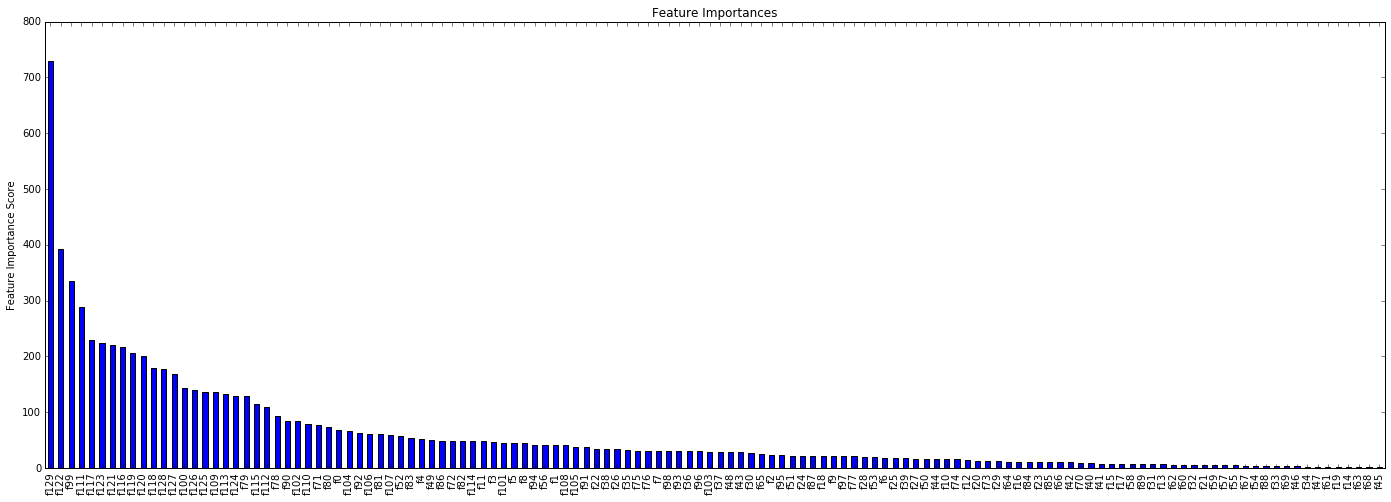

In [10]:
# predictors = [x for x in X_train.columns ] 
xgb2 = XGBRegressor( learning_rate =0.2, 
                     n_estimators=1000, 
                     max_depth=5, min_child_weight=7, gamma=0.4, subsample=0.8, 
                     colsample_bytree=0.8, objective= 'reg:linear', nthread=8, 
                     scale_pos_weight=1, seed=27, silent=1)
# xgb1.fit(X_train, y_train,eval_metric='mae')

modelfit(xgb2, X_train, y_train)

In [13]:
param_test4 = { 'subsample':[i/10.0 for i in range(6,10)], 'colsample_bytree':[i/10.0 for i in range(6,10)] }

gsearch4 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.2, n_estimators=280, max_depth=5, 
                                                  min_child_weight=7, gamma=0.4, subsample=0.8, colsample_bytree=0.8, 
                                                  objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=27), 
                                                  param_grid = param_test4, scoring='neg_mean_absolute_error',
                                                  n_jobs=4,iid=False, cv=5) 
gsearch4.fit(X_train, y_train) 
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: -0.41899, std: 0.00201, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: -0.41871, std: 0.00229, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: -0.41820, std: 0.00187, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: -0.41750, std: 0.00182, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: -0.41931, std: 0.00215, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: -0.41866, std: 0.00194, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: -0.41781, std: 0.00204, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: -0.41773, std: 0.00201, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: -0.41952, std: 0.00240, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: -0.41850, std: 0.00208, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: -0.41776, std: 0.00187, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: -0.41779, std: 0.00203, params: {'colsample_bytree': 0.8,

In [14]:
param_test5 = { 'subsample':[i/100.0 for i in range(85,100,5)], 'colsample_bytree':[i/100.0 for i in range(55,70,5)] }

gsearch5 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.2, n_estimators=280, max_depth=5, 
                                                  min_child_weight=7, gamma=0.4, subsample=0.8, colsample_bytree=0.8, 
                                                  objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=27), 
                                                  param_grid = param_test5, scoring='neg_mean_absolute_error',
                                                  n_jobs=4,iid=False, cv=5) 
gsearch5.fit(X_train, y_train) 
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_



([mean: -0.41811, std: 0.00212, params: {'colsample_bytree': 0.55, 'subsample': 0.85},
  mean: -0.41763, std: 0.00198, params: {'colsample_bytree': 0.55, 'subsample': 0.9},
  mean: -0.41787, std: 0.00219, params: {'colsample_bytree': 0.55, 'subsample': 0.95},
  mean: -0.41777, std: 0.00187, params: {'colsample_bytree': 0.6, 'subsample': 0.85},
  mean: -0.41750, std: 0.00182, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: -0.41765, std: 0.00223, params: {'colsample_bytree': 0.6, 'subsample': 0.95},
  mean: -0.41747, std: 0.00215, params: {'colsample_bytree': 0.65, 'subsample': 0.85},
  mean: -0.41789, std: 0.00202, params: {'colsample_bytree': 0.65, 'subsample': 0.9},
  mean: -0.41753, std: 0.00215, params: {'colsample_bytree': 0.65, 'subsample': 0.95}],
 {'colsample_bytree': 0.65, 'subsample': 0.85},
 -0.4174665457812294)

In [17]:
param_test6 = { 'reg_alpha':[7.5, 10, 15] }

gsearch6 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.2, n_estimators=280, max_depth=5, 
                                                  min_child_weight=7, gamma=0.4, subsample=0.85, colsample_bytree=0.65, 
                                                  objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=27), 
                                                  param_grid = param_test6, scoring='neg_mean_absolute_error',
                                                  n_jobs=4,iid=False, cv=5) 
gsearch6.fit(X_train, y_train) 
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: -0.41647, std: 0.00194, params: {'reg_alpha': 7.5},
  mean: -0.41616, std: 0.00185, params: {'reg_alpha': 10},
  mean: -0.41669, std: 0.00206, params: {'reg_alpha': 15}],
 {'reg_alpha': 10},
 -0.4161571571769295)

[0]	train-mae:3030.36+1.16547	train-rmse:5.79826+0.000217483	test-mae:3030.36+4.65945	test-rmse:5.79824+0.00088668
[10]	train-mae:1811.98+2.17973	train-rmse:0.860913+0.000652596	test-mae:1812.97+4.10497	test-rmse:0.86175+0.00102687
[20]	train-mae:1251.17+2.141	train-rmse:0.57126+0.00050839	test-mae:1256.38+5.95309	test-rmse:0.573697+0.00162467
[30]	train-mae:1193.87+1.34688	train-rmse:0.555232+0.000292916	test-mae:1202.14+5.75951	test-rmse:0.558871+0.00142274
[40]	train-mae:1174.95+1.63983	train-rmse:0.548526+0.000505322	test-mae:1185.51+5.15721	test-rmse:0.552959+0.00106833
[50]	train-mae:1164.17+1.34211	train-rmse:0.544451+0.000372654	test-mae:1177.01+4.94742	test-rmse:0.54969+0.000728442
[60]	train-mae:1157.12+1.24824	train-rmse:0.541669+0.000299676	test-mae:1171.63+5.33434	test-rmse:0.547625+0.000854838
[70]	train-mae:1151.4+1.11502	train-rmse:0.539357+0.000208112	test-mae:1167.59+5.30462	test-rmse:0.545968+0.00077168
[80]	train-mae:1146.72+1.33118	train-rmse:0.537409+0.000348856	t

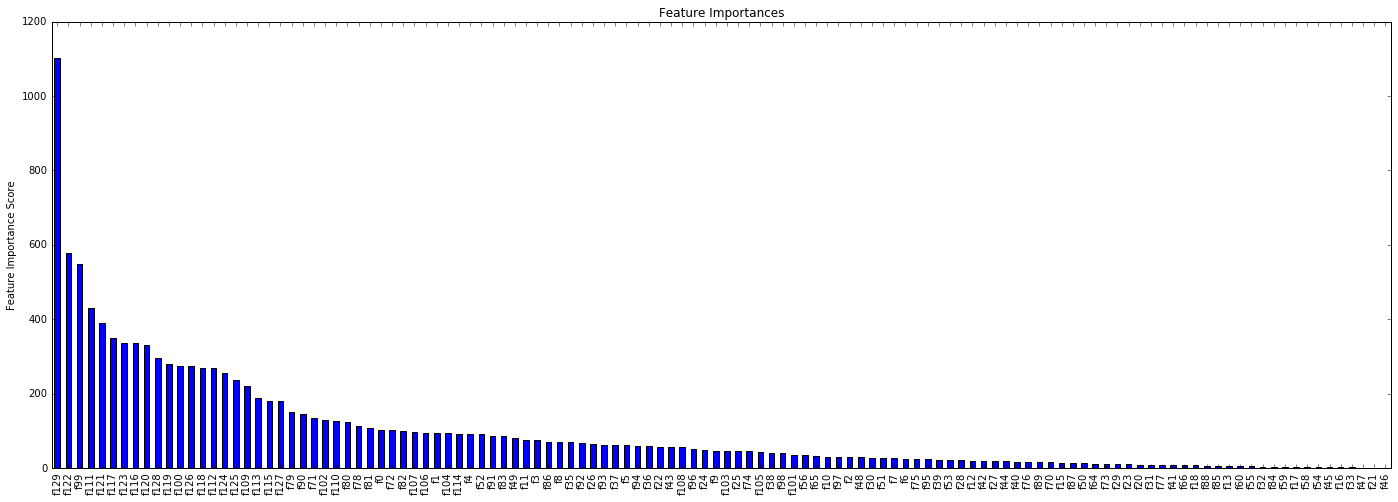

In [18]:
# predictors = [x for x in X_train.columns ] 
xgb3 = XGBRegressor( learning_rate =0.2, 
                     n_estimators=1000, reg_alpha=10,
                     max_depth=5, min_child_weight=7, gamma=0.4, subsample=0.85, 
                     colsample_bytree=0.65, objective= 'reg:linear', nthread=8, 
                     scale_pos_weight=1, seed=27, silent=1)
# xgb1.fit(X_train, y_train,eval_metric='mae')

modelfit(xgb3, X_train, y_train)

In [20]:
param_test7 = { 'learning_rate':[0.2, 0.3, 0.5] }

gsearch7 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.2, n_estimators=280, max_depth=5, reg_alpha=10,
                                                  min_child_weight=7, gamma=0.4, subsample=0.85, colsample_bytree=0.65, 
                                                  objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=27), 
                                                  param_grid = param_test7, scoring='neg_mean_absolute_error',
                                                  n_jobs=4,iid=False, cv=5) 
gsearch7.fit(X_train, y_train) 
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

([mean: -0.41616, std: 0.00185, params: {'learning_rate': 0.2},
  mean: -0.41737, std: 0.00197, params: {'learning_rate': 0.3},
  mean: -0.42132, std: 0.00150, params: {'learning_rate': 0.5}],
 {'learning_rate': 0.2},
 -0.4161571571769295)

In [21]:
xgbr = XGBRegressor(learning_rate =0.2, n_estimators=280, max_depth=5, reg_alpha=10, min_child_weight=7, 
                    gamma=0.4, subsample=0.85, colsample_bytree=0.65, 
                    objective= 'reg:linear', nthread=4, scale_pos_weight=1,seed=27)

In [28]:
gbm = xgbr.fit(X_train, y_train, eval_metric='mae') 

In [29]:
y_pred = gbm.predict(X_test)

In [30]:
y_pred = np.exp(y_pred)
output = pd.DataFrame({
        "ID": df_test["id"],
        "loss": y_pred[:]
    })
output.to_csv("../input/xgb_output.csv", index=False)